# Training and deploying a tabular model using Vertex AutoML - Part 1


![Training pipeline](../images/automl.png)

## Import the required packages

In [1]:
import os
import pprint
import pandas as pd
import time

import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.cloud import exceptions

## Configure GCP settings

*Before running the notebook make sure to follow the repo's README file to install the pre-requisites and configure GCP authentication.*

In [2]:
PROJECT = 'jk-vertex-workshop'
REGION = 'us-central1'
PREFIX = 'jk1'

## Preparing training data in BigQuery

### Explore Chicago Taxi dataset

In [3]:
%%bigquery data

SELECT 
    *
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
LIMIT 3

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.57rows/s]


In [4]:
data.head().T

0  \
unique_key                       ccc4a6dff0ad0e45d63e17f20b1659b06a7c913e   
taxi_id                 2ff33fa77fef652380380c5128fcb9406473110e8377cf...   
trip_start_timestamp                            2016-06-10 18:15:00+00:00   
trip_end_timestamp                              2016-06-10 18:15:00+00:00   
trip_seconds                                                          720   
trip_miles                                                            2.8   
pickup_census_tract                                                   NaN   
dropoff_census_tract                                                  NaN   
pickup_community_area                                                 NaN   
dropoff_community_area                                                NaN   
fare                                                                 10.2   
tips                                                                 2.44   
tolls                                                                 NaN   
extras                                                                2.0   
trip_total                                                          14.64   
payment_type                                                  Credit Card   
company                                                          303 Taxi   
pickup_latitude                                                       NaN   
pickup_longitude                                                      NaN   
pickup_location                                                      None   
dropoff_latitude                                                      NaN   
dropoff_longitude                                                     NaN   
dropoff_location                                                     None   

                                                                        1  \
unique_key                       bd5c3b14f6c1e82ee6c179c7d910ed9f66186051   
taxi_id                 3cc82aa4b38ba2e05b13f2db7765fd11ad9120d7ac2f2e...   
trip_start_timestamp                            2016-06-12 18:15:00+00:00   
trip_end_timestamp                              2016-06-12 18:30:00+00:00   
trip_seconds                                                          805   
trip_miles                                                            3.8   
pickup_census_tract                                                   NaN   
dropoff_census_tract                                                  NaN   
pickup_community_area                                                 NaN   
dropoff_community_area                                                NaN   
fare                                                                 12.6   
tips                                                                  0.0   
tolls                                                                 NaN   
extras                                                                0.0   
trip_total                                                           12.6   
payment_type                                                         Cash   
company                                                          303 Taxi   
pickup_latitude                                                       NaN   
pickup_longitude                                                      NaN   
pickup_location                                                      None   
dropoff_latitude                                                      NaN   
dropoff_longitude                                                     NaN   
dropoff_location                                                     None   

                                                                        2  
unique_key                       4350534a2260badcf579ce5e0bb19634bc0dc966  
taxi_id                 3cc82aa4b38ba2e05b13f2db7765fd11ad9120d7ac2f2e...  
trip_start_timestamp                            2016-06-13 08:30:00+00:00  
trip_end_timestamp                              2016-06-13 08:30:00+00

In [5]:
%%bigquery data

SELECT 
    CAST(EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS string) AS trip_dayofweek, 
    FORMAT_DATE('%A',cast(trip_start_timestamp as date)) AS trip_dayname,
    COUNT(*) as trip_count,
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
    EXTRACT(YEAR FROM trip_start_timestamp) = 2015 
GROUP BY
    trip_dayofweek,
    trip_dayname
ORDER BY
    trip_dayofweek

Downloading: 100%|██████████| 7/7 [00:01<00:00,  4.10rows/s]


In [6]:
data

trip_dayofweek trip_dayname  trip_count
0              1       Sunday     4141154
1              2       Monday     4105900
2              3      Tuesday     4378805
3              4    Wednesday     4542810
4              5     Thursday     4918190
5              6       Friday     5289830
6              7     Saturday     5009186

<AxesSubplot:xlabel='trip_dayname'>

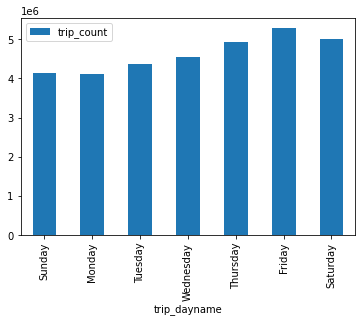

In [7]:
data.plot(kind='bar', x='trip_dayname', y='trip_count')

### Create data splits

In [8]:
BQ_DATASET_NAME = f'{PREFIX}_dataset' 
BQ_TABLE_NAME = 'features'
BQ_LOCATION = 'US'
SAMPLE_SIZE = 500000
YEAR = 2020

#### Create a BQ dataset to host the splits

In [9]:
client = bigquery.Client()

dataset_id = f'{PROJECT}.{BQ_DATASET_NAME}'
dataset = bigquery.Dataset(dataset_id)
dataset.location = BQ_LOCATION

try:
    dataset = client.create_dataset(dataset, timeout=30)
    print('Created dataset: ', dataset_id)
except exceptions.Conflict:
    print('Dataset {} already exists'.format(dataset_id))

Dataset jk-vertex-workshop.jk1_dataset already exists


#### Create a table with training features

In [10]:
sample_size = 1000000
year = 2020

sql_script_template = '''
CREATE OR REPLACE TABLE `@PROJECT.@DATASET.@TABLE` 
AS (
    WITH
      taxitrips AS (
      SELECT
        FORMAT_DATETIME('%Y-%d-%m', trip_start_timestamp) AS date,
        trip_start_timestamp,
        trip_seconds,
        trip_miles,
        payment_type,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        tips,
        fare
      FROM
        `bigquery-public-data.chicago_taxi_trips.taxi_trips`
      WHERE 1=1 
      AND pickup_longitude IS NOT NULL
      AND pickup_latitude IS NOT NULL
      AND dropoff_longitude IS NOT NULL
      AND dropoff_latitude IS NOT NULL
      AND trip_miles > 0
      AND trip_seconds > 0
      AND fare > 0
      AND EXTRACT(YEAR FROM trip_start_timestamp) = @YEAR
    )

    SELECT
      trip_start_timestamp,
      EXTRACT(MONTH from trip_start_timestamp) as trip_month,
      EXTRACT(DAY from trip_start_timestamp) as trip_day,
      EXTRACT(DAYOFWEEK from trip_start_timestamp) as trip_day_of_week,
      EXTRACT(HOUR from trip_start_timestamp) as trip_hour,
      trip_seconds,
      trip_miles,
      payment_type,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(pickup_longitude, pickup_latitude), 0.1)
      ) AS pickup_grid,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(dropoff_longitude, dropoff_latitude), 0.1)
      ) AS dropoff_grid,
      ST_Distance(
          ST_GeogPoint(pickup_longitude, pickup_latitude), 
          ST_GeogPoint(dropoff_longitude, dropoff_latitude)
      ) AS euclidean,
      IF((tips/fare >= 0.2), 1, 0) AS tip_bin,
      CASE (ABS(MOD(FARM_FINGERPRINT(date),10))) 
          WHEN 9 THEN 'TEST'
          WHEN 8 THEN 'VALIDATE'
          ELSE 'TRAIN' END AS data_split
    FROM
      taxitrips
    LIMIT @LIMIT
)
'''

sql_script = sql_script_template.replace(
    '@PROJECT', PROJECT).replace(
    '@DATASET', BQ_DATASET_NAME).replace(
    '@TABLE', BQ_TABLE_NAME).replace(
    '@YEAR', str(year)).replace(
    '@LIMIT', str(sample_size))

job = client.query(sql_script)
job.result()

#### Review the created features

In [11]:
sql_script = f'''
SELECT * EXCEPT (trip_start_timestamp)
FROM {PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME} 
'''
df = client.query(sql_script).result().to_dataframe()

In [12]:
df.head().T

0                  1                  2  \
trip_month                        6                  6                  6   
trip_day                         19                 19                 19   
trip_day_of_week                  6                  6                  6   
trip_hour                         0                  0                  0   
trip_seconds                    241                660                480   
trip_miles                     0.77                1.1                1.5   
payment_type                   Cash               Cash               Cash   
pickup_grid       POINT(-87.7 41.9)  POINT(-87.7 41.9)  POINT(-87.6 41.9)   
dropoff_grid      POINT(-87.7 41.9)  POINT(-87.6 41.9)  POINT(-87.6 41.9)   
euclidean                       0.0         3788.78383                0.0   
tip_bin                           0                  0                  0   
data_split                    TRAIN              TRAIN              TRAIN   

                                  3                  4  
trip_month                        6                  6  
trip_day                         19                 19  
trip_day_of_week                  6                  6  
trip_hour                         0                  0  
trip_seconds                   1200                900  
trip_miles                      4.1                0.4  
payment_type                   Cash            Unknown  
pickup_grid       POINT(-87.6 41.8)  POINT(-87.7 41.9)  
dropoff_grid      POINT(-87.7 41.9)  POINT(-87.6 41.8)  
euclidean               2210.049904       10666.168995  
tip_bin                           0                  0  
data_split                    TRAIN              TRAIN